# The 1D Vlasov-Ampere equations

We consider the Vlasov equation for electrons with a steady background of ions in 2D phase-space $(x,v = vx)$ coupled to the Maxwell equations. As our Vlasov equation can only contain currents in the x directions, and as the Maxwell equation decouples in 1D into a longitudinal part and a transverse part which is source free. The propagating electromagnetic field remains zero for all times if it is zero at the initial time. Hence, the model is restricted to the following Vlasov–Ampere system

$$
\frac{\partial f}{\partial dt} + \text{v} \frac{\partial f}{\partial x}
−\frac{e}{m} E(t,x) \frac{\partial f}{\partial \text{v}} = 0.
$$

$$
\frac{\partial E}{\partial dt} = - \frac{J}{\epsilon_0} = \frac{e}{\epsilon_0}\int f \text{v} d\text{v}
$$

where $J = −e \int f \text{v} d\text{v}$.

## Algorithm 

- For each $j$ compute discrete Fourier transform in $x$ of $f_n(x_i,\text{v}_j)$ yielding $f_k^n(\text{v}_j)$, 
- For $ k \neq 0 $:
    - Compute $f^{n+1}_k (\text{v}_j) = e^{−2i\pi k \text{v} \Delta t / L } f^n(\text{v}_j)$,
    - Compute $\rho^{n+1} =\Delta \text{v}  f^{n+1}(\text{v}_j),$
    - Compute $E^{n+1}_k = \rho^{n+1}_k (eL)/(2i\pi k \epsilon_0)$,
- For $k = 0$ do nothing: $f_k^{n+1}(\text{v}_j) = f^n_k(\text{v}_j), E^{n+1}_k = E^n_k$.
- Perform inverse discrete Fourier transform of $E^{n+1}_k$ and for each $j$ of $f^{n+1}_k (\text{v}_j)$.


In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 8.0)
%load_ext cython

WARNING  Pythran support disabled for module: omp


In [25]:
%%cython -3 -c=-O3
import cython
import numpy as np
cimport cython
cimport numpy as np
from libc.math cimport floor, sqrt

ctypedef np.float64_t dtype_t

@cython.boundscheck(False)
@cython.cdivision(True)
cpdef double[:] compute_interpolants( int n, double[:] f ):
        
    cdef int num_terms
    cdef double a,b, r_a, r_b, d1, coeff_tmp
    cdef Py_ssize_t i
    cdef double[:] coeffs
    cdef double[:] d
    
    num_terms = 27
    
    coeffs = np.zeros(n+3)
    d = np.zeros(n)

    a   = sqrt((2.0+sqrt(3.0))/6.0)
    r_a = 1.0/a
    b   = sqrt((2.0-sqrt(3.0))/6.0)
    b_a = b/a

    d1 = f[0]
    coeff_tmp = 1.0
    for i in range(num_terms):
        coeff_tmp *= (-b_a)
        d1 += coeff_tmp*f[n-2-i]

    d[0] = d1*r_a
    for i in range(1,n-1):
        d[i] = r_a*(f[i] - b*d[i-1])
        
    d1        = d[-2]
    coeff_tmp = 1.0
    for i in range(num_terms):
        coeff_tmp *= (-b_a)
        d1 += coeff_tmp*d[i]

    coeffs[n-1] = d1*r_a
    
    for i in range(n-2, 0, -1):
        coeffs[i] = r_a*(d[i-1] - b*coeffs[i+1])

    coeffs[0]  = coeffs[-4]
    coeffs[-1:-4:-1] = coeffs[3:0:-1]
        
    return coeffs



@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef double interpolate( 
    double[:] coeffs, 
    int n,
    double xmin, 
    double xmax, 
    double x ) nogil:
        
    cdef double rh, dx, cdx, cell
    cdef double cim1, ci, cip1, cip2
    cdef double t0, t1, t2, t3, t4
    cdef Py_ssize_t icell
    
    rdelta = (n-1) / (xmax - xmin)
    rh  = rdelta
    
    t0      = (x-xmin)*rh
    cell    = floor(t0)
    dx      = t0 - cell
    cdx     = 1.0 - dx
    icell   = int(cell)
    cim1    = coeffs[icell]
    ci      = coeffs[icell+1]
    cip1    = coeffs[icell+2]
    cip2    = coeffs[icell+3]
    t1      = 3.0*ci
    t3      = 3.0*cip1
    t2      = cdx*(cdx*(cdx*(cim1 - t1) + t1) + t1) + ci
    t4      =  dx*( dx*( dx*(cip2 - t3) + t3) + t3) + cip1
            
    return (t2 + t4) / 6.0

@cython.boundscheck(False)
def advection_v(np.ndarray [dtype_t, ndim=2] f, 
                np.ndarray [dtype_t, ndim=1] v, 
                int nx, int nv, 
                double vmin, double vmax, 
                double[:] e, 
                double dt):
    
    cdef double[:] coeffs 

    cdef Py_ssize_t i, j
    cdef double v_new
    for i in range(nx):
        coeffs = compute_interpolants(nv, f[:,i] )       
        for j in range(nv):
            v_new = v[j] - dt * e[i] 
            v_new = vmin + (v_new - vmin)%(vmax-vmin) #(b + (a%b)) % b
            f[j,i] = interpolate(coeffs, nv, vmin, vmax, v_new)
    return f
            

In [26]:
import progressbar

class VlasovMaxwell:
    
    def __init__(self, xmin, xmax, nx, vmin, vmax, nv):
        
        # Grid
        self.nx = nx
        self.x, self.dx = np.linspace(xmin, xmax, nx, endpoint=False, retstep=True)
        self.nv = nv
        self.v, self.dv = np.linspace(vmin, vmax, nv, endpoint=False, retstep=True)
        self.vmin = vmin
        self.vmax = vmax
        self.Lx = xmax - xmin
        
        # Distribution function
        self.f = np.zeros((nx,nv)) 
       
        # Modes for Poisson equation
        self.modes = np.zeros(nx-1)
        k =  2* np.pi / (xmax - xmin)
        self.modes[:nx//2-1] = k * np.arange(1,nx//2)
        self.modes[nx//2-1:] = - k * np.arange(nx//2,0,-1)
        
    def compute_rho(self):
        return  self.dv * np.sum(self.f, axis=0)
                    
        
    def advection_x(self, e, dt):
        
        for j in range(self.nv):
            
            alpha = dt * self.v[j]      
            fk =  fft(self.f[j,1:])    
            fk *=  np.cos(self.modes*alpha) - 1j * np.sin(self.modes*alpha)    
            r1 = self.dv * np.sum(fk)    
            self.f[j,1:] =   ifft(fk) / nx
            ek = fft(e[1:])    
            ek =  - r1 * (1j * self.Lx) / (1j*2.0*np.pi*self.x[1:])
            e[1:] = ifft(ek) / nx
            return e
    
            
    def advection_v(self, e, dt):
        
        self.f = advection_v(self.f, self.v, self.nx, self.nv, 
                             self.vmin, self.vmax, e, dt)
            
    
    def run(self, f, e, nstep, dt):
        self.f = f
        nrj = []
        bar = progressbar.ProgressBar()
        e = self.advection_x(e,0.5*dt)
        for istep in bar(range(nstep)):
            rho = self.compute_rho()
            self.advection_v(e, dt)
            e = self.advection_x(e, dt)
            nrj.append( 0.5*np.log(np.sum(e*e)*self.dx))
                
        return nrj

# Landau Damping

[Landau damping - Wikipedia](https://en.wikipedia.org/wiki/Landau_damping)

In [27]:
from time import time

    
# Set grid
nx, nv = 64, 64
xmin, xmax = 0.0, 4*np.pi
vmin, vmax = -6., 6.

# Create Vlasov-Poisson simulation
sim = VlasovMaxwell(xmin, xmax, nx, vmin, vmax, nv)

# Initialize distribution function and electric field
X, V = np.meshgrid(sim.x, sim.v)
eps, kx = 0.01, 0.5
f = (1.0+eps*np.cos(kx*X))/(2.0*np.pi)* np.exp(-0.5*V*V)
e = 4/(np.pi*np.pi)*eps/kx * np.sin(kx*sim.x)

# Set time domain
nstep = 1000
t, dt = np.linspace(0.0, 40.0, nstep, retstep=True)

# Run simulation
etime = time()
nrj = sim.run(f, e, nstep, dt)
print(" Elapsed time : {0:.4f} ".format(time()-etime))



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
100% (1000 of 1000) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


 Elapsed time : 0.8231 


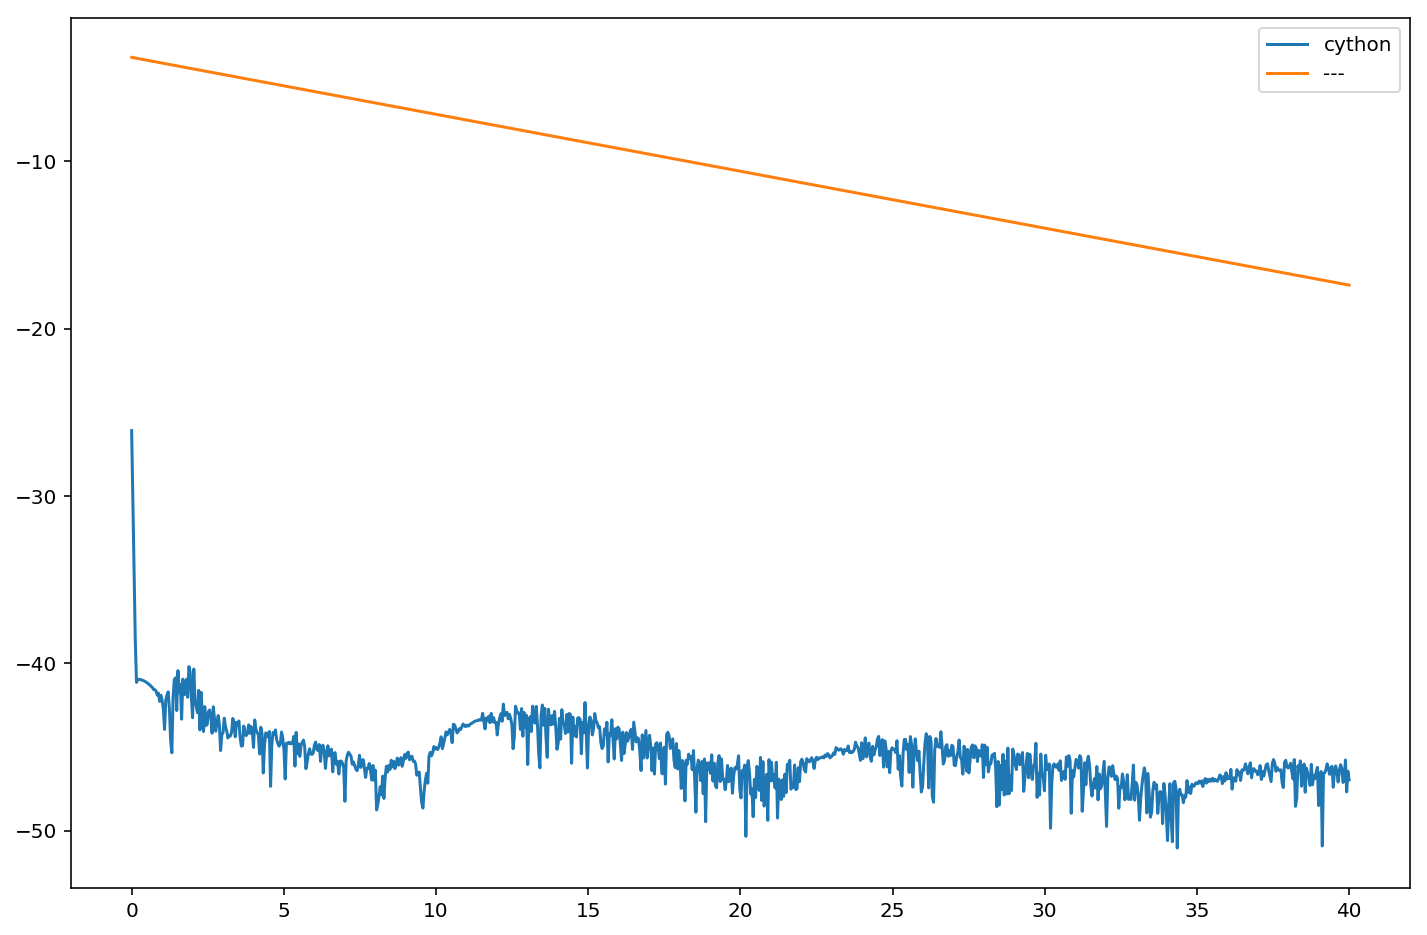

In [28]:
fig, axes = plt.subplots()
plt.plot(t, nrj, label='cython')
plt.plot(t, -3.8-0.34*t, label='---');
plt.legend();

# References
- [Optimizing Python with NumPy and Numba](https://jakevdp.github.io/blog/2015/02/24/optimizing-python-with-numpy-and-numba/)
- [Suck-less scientific Python](https://dionhaefner.github.io/2016/11/suck-less-scientific-python-part-2-efficient-number-crunching/)


In [41]:
nx = 8
modes = np.zeros(nx-1)
modes[:nx//2-1] = np.arange(1,nx//2)
modes[nx//2-1:] = - np.arange(nx//2,0,-1)
modes

array([ 1.,  2.,  3., -4., -3., -2., -1.])

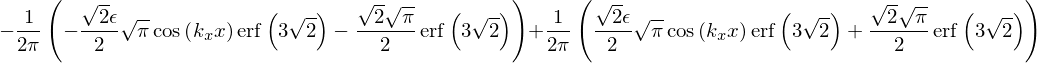

In [10]:
from sympy import *
init_printing()
epsilon, k_x, x, v = symbols('epsilon k_x x v')
f_sym = (1+epsilon*cos(k_x*x))/(2*pi)* exp(-v*v/2)
rho_sym = integrate(f_sym,(v,-6,6))
rho_sym

In [42]:
import scipy
rho_init = lambdify((x,epsilon,k_x), expr, modules=['numpy', {'erf':scipy.special.erf}])
vx = np.linspace(0,4*np.pi, 100)
rho = rho_init(vx,0.01,0.5)
rho = rho - rho.mean()
e = np.gradient(rho, edge_order=2)

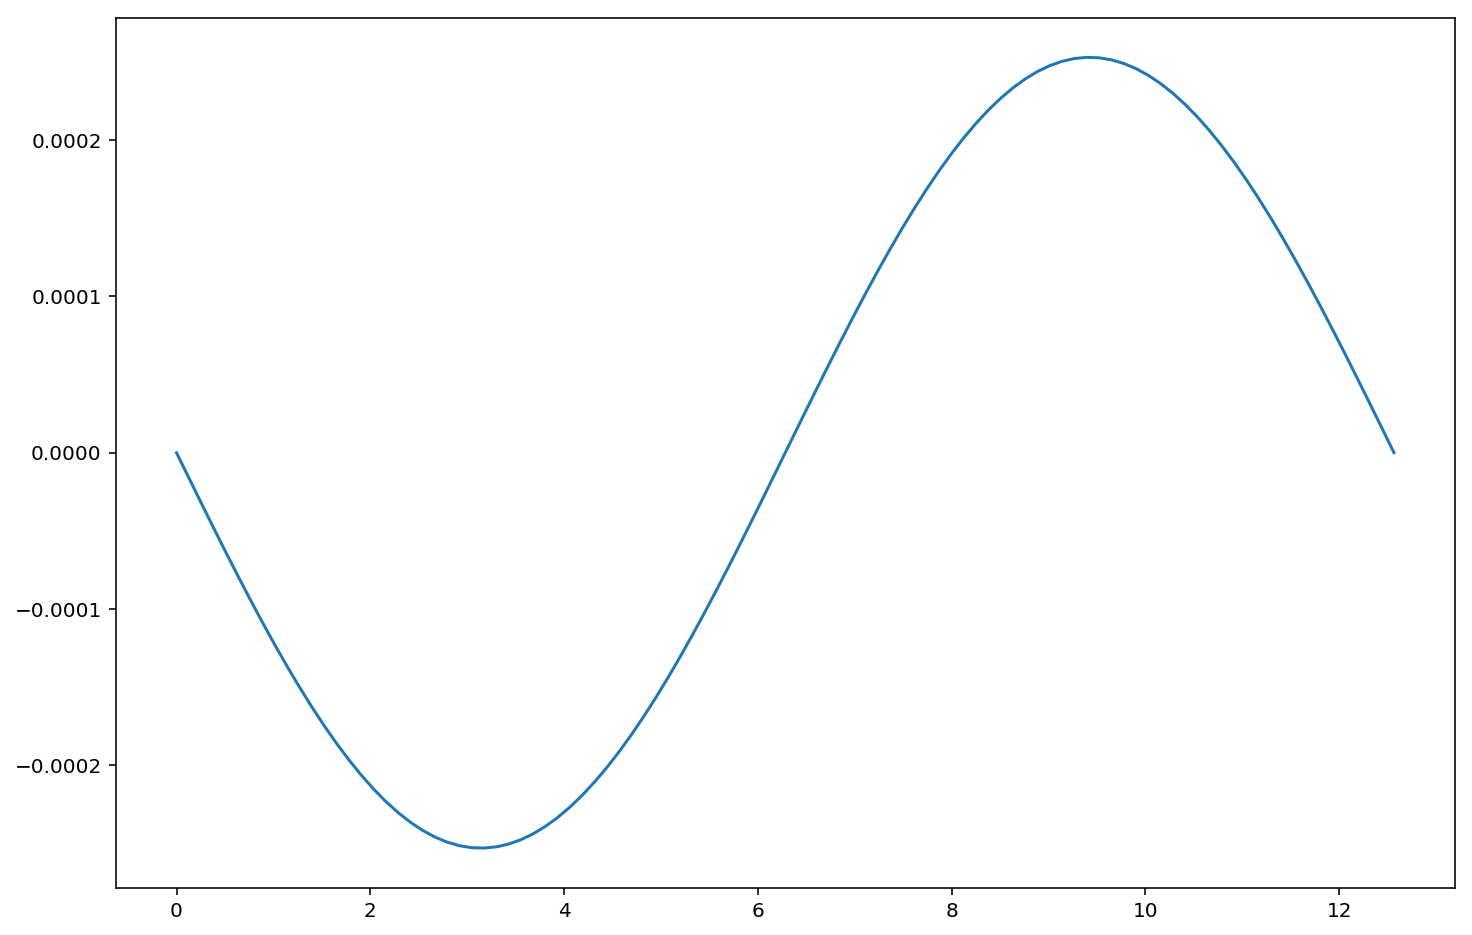

In [43]:
plt.plot(vx, e)